## Replication code 
- Step 1: Download, clean and combine several data:
    - WEO: World Economic Outlook database (GDP in dollars)
    - CBCR: IRS Country by Country Reporting (Profit, employees and sales of US multinationals)
    - GRD: Government Revenue Dataset (Government corporate and tax revenues)
    - Data on statutory tax rate: Please cite _Janský, Petr; Palanský, Miroslav (2018) : Estimating the scale of profit shifting and tax revenue losses related to foreign direct investment, WIDER Working Paper, No. 2018/21, ISBN 978-92-9256-463-6, The United Nations University World Institute for Development Economics Research (UNU-WIDER), Helsinki_
- Step 2:
    - Create the models, where profits are allocated in terms of employees and sales, and the formulas of IMF, OECD, OECD with only 20% of residual profits apportioned, and GFA
- Step 3:
    - Create summary statistics per income group
- Step 4:
    - Create visualizations using:
        - All countries
        - Countries with positive profits
        - Countries with positive gains
        - Countries with positive profits and gains
    
------------

- Requirements:
    - Python3 and data processing libraries. The easier way to get all the requirements is to install Anaconda: https://www.anaconda.com/distribution/
    - The interactive visualizations require the library altair. If Anaconda is installed you can install altair running: conda install -c conda-forge altair vega_datasets notebook vega
    - The scatter plots use adjusttext (https://github.com/Phlya/adjustText) to avoid overlaps between the labels, install with: conda install -c phlya adjusttext 
    
- Usage:
    - Update the links below with the most recent version of the data. Reflect the changes in the file names as well. Please note that the code will break if the format of the files changes at some point (e.g. change in column names of WEO or CBCR or change in column order for GRD). 
    - Run the rest of the code in order
    

## Edit the following links with the newest urls

In [1]:
#urls
ictd_file = "https://www.wider.unu.edu/sites/default/files/Data/ICTDWIDERGRD_2019.xlsx"
weo_file = "https://www.imf.org/external/pubs/ft/weo/2018/01/weodata/WEOApr2018all.xls"
cbcr_file = "https://www.irs.gov/pub/irs-soi/16it01acbc.xlsx"

#names of files
ictd_clean = "ICTD_2019.xlsx"
weo_clean = "WEO_Apr2018.tsv"
cbcr_clean = "CBCR2016.xlsx"

#Year study (the most recent year for CBCR)
year_study = 2016

#Merged file name
merged_file = "merged_Sep19.tsv"

#Save figures and tables here
path_results = "Sep19"

import os 
if not os.path.exists(path_results):
    os.makedirs(path_results)


In [2]:

#Keep only countries with positive gains
positive_gains = False

#Keep only countries with positive profits
positive_profits = False

if (not positive_gains) and (not positive_profits):
    if not os.path.exists(path_results+"/all_countries"):
        os.makedirs(path_results+"/all_countries")
    path_results = path_results+"/all_countries"
elif positive_gains and positive_profits:
    if not os.path.exists(path_results+"/pos_gains_and_pos_prof"):
        os.makedirs(path_results+"/pos_gains_and_pos_prof")
    path_results = path_results+"/pos_gains_and_pos_prof"
elif positive_gains:
    if not os.path.exists(path_results+"/pos_gains"):
        os.makedirs(path_results+"/pos_gains")
    path_results = path_results+"/pos_gains"
elif positive_profits:
    if not os.path.exists(path_results+"/pos_prof"):
        os.makedirs(path_results+"/pos_prof")
    path_results = path_results+"/pos_prof"

In [3]:
if not os.path.exists(path_results+"/Figures"):
    os.makedirs(path_results+"/Figures")
if not os.path.exists(path_results+"/Tables"):
    os.makedirs(path_results+"/Tables")
    

# Code

### Imports

In [4]:
#Standard visualization/data tools
import pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML

#Processes
import os #file processes
import urllib #download files
import pickle #read the pickled dictionaries

#Interactive visualizations
import altair as alt
alt.renderers.enable('notebook')

#Avoid overlaps in labels of scatter plto
from adjustText import adjust_text

#Plot in notebook
%matplotlib inline

#Change the defaults of visualizations a bit
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

### Read useful data

In [5]:
#Dictionaries to convert from name to ISO2 and from ISO3 to ISO2
#Country name to ISO2
name2iso2 = pickle.load(open("Data/name2iso.dump","rb"))
#ISO3 to ISO2
iso3_to_iso2 = pickle.load(open("Data/iso3_2_iso2.dump","rb"))

list_tax_havens = ["Stateless entities and other country","Mauritius","Aruba","Bahamas","Barbados","Bermuda","British Virgin Islands","Cayman Islands","Curacao","Panama","St. Kitts and Nevis","St. Lucia Island","Trinidad and Tobago","Virgin Islands","Guam","Hong Kong","Macau","Saudi Arabia","Singapore","United Arab Emirates","Cyprus","Guernsey","Ireland","Jersey","Luxembourg","Malta","Monaco","Netherlands","Switzerland","Puerto Rico"]
list_tax_havens_iso2 = set([name2iso2[th] for th in list_tax_havens]) #set for faster lookup

# Step 1. Download, clean and combine several data
- The files can also be downloaded by hand and placed in the Data folder

### 1.1 Download data

In [6]:
#Check if the files have already been downloaded to speed it up
files = os.listdir("Data")

#ICTD
if ictd_clean not in files:
    urllib.request.urlretrieve(ictd_file,"./Data/{}".format(ictd_clean))

#WEO
if weo_clean not in files:
    urllib.request.urlretrieve(weo_file,"./Data/{}".format(weo_clean))

#CBCR
if cbcr_clean not in files:
    urllib.request.urlretrieve(cbcr_file, "./Data/{}".format(cbcr_clean))

### 1.2 Clean data

#### 1.2.1 Clean WEO data

In [7]:
#CLEAN WEO DATA

weo_data = pd.read_csv("./Data/{}".format(weo_clean),sep="\t",encoding="latin1")

#Keep relevant columns
weo_data = weo_data.loc[weo_data["WEO Subject Code"]=="NGDPD",["ISO","Country","Subject Descriptor","Units","Scale", "Country/Series-specific Notes", str(year_study),"Estimates Start After"]]

#Convert from Billions to dollars
weo_data["GDP_USD"] = weo_data[str(year_study)].str.replace(",","").astype(float)
weo_data["GDP_USD"] *= 1E9
weo_data["Scale"] = "Dollars"

#Convert ISO3 to ISO2
weo_data["ISO2"] = weo_data["ISO"].map(iso3_to_iso2)

#Save to file 
weo_data.to_csv("./Data/cleaned_{}".format(weo_clean),sep="\t",index=None)

#### 1.2.2 Clean GRD data

In [8]:
#CLEAN GRD DATA
ictd_data = pd.read_excel("./Data/{}".format(ictd_clean),sheet_name="Merged",skiprows=2,keep_default_na=False,na_values=[""])

#Replacing the columns with numbers because of the multi-level olumns
ictd_data.columns = range(len(ictd_data.columns))
#Keeping the right columns
ictd_data = ictd_data.loc[:,[3,4,5,6,7,23,36,38,24]]
#New column names
ictd_data.columns = ["Country","Reg","Inc","Year_GRD","ISO","TotTax (X)","CIT (AK)","CITnr (AM)","TTxsc (Y)"]

#Convert Reg and Inc to text
d_income = {1:"LICs",2:"LMICs",3:"UMICs",4:"High Income"}
ictd_data["Inc"] = ictd_data["Inc"].map(d_income)
d_region = {1:"East Asia & Pacific",2:"Europe & Central Asia",3:"Latin America & The Caribbean",4:"Middle East & North Africa",5:"North America",6:"South Asia",7:"Sub - Saharan Africa"}
ictd_data["Reg"] = ictd_data["Reg"].map(d_region)


#Using the GDP from the GDP series sheet since it seems to be missing in the "Merged" sheet
ictd_gdp = pd.read_excel("./Data/{}".format(ictd_clean),sheet_name="GDP Series",skiprows=1)
years = list(ictd_gdp.columns)[1:-2]
ictd_gdp = ictd_gdp.melt(id_vars="ISO",value_vars=years,value_name="GDP_LCU",var_name="Year").dropna()

#Print number of countries
print(len(ictd_data["ISO"].unique()))

#Merge GDP to the other and make sure we don't lose countries
ictd_data = pd.merge(ictd_data,ictd_gdp)
print(len(ictd_data["ISO"].unique()))

#Keep only reasonable recent years and make sure we don't lose countries
ictd_data = ictd_data.loc[(ictd_data["Year_GRD"]>year_study-5)]
print(len(ictd_data["ISO"].unique()))

#Create column number_datapoints with the number of non-missing values
ictd_data["number_datapoints"] = ictd_data.groupby(["Country","Year_GRD"])[["GDP_LCU","TotTax (X)","CIT (AK)","CITnr (AM)","TTxsc (Y)"]].transform(np.isfinite).sum(1)
#Keep the most recent year with the maximum number of points
ictd_data = ictd_data.sort_values(by=["number_datapoints","Year_GRD"], ascending=False).groupby("Country").head(1)

#Make sure we don't lose countries
print(len(ictd_data["ISO"].unique()))

#Convert to iso2
ictd_data["ISO2"] = ictd_data["ISO"].map(iso3_to_iso2)
#Save to file 
ictd_data.to_csv("./Data/cleaned_{}".format(ictd_clean),sep="\t",index=None)

196
196
196
196


#### 1.2.3 Clean CBCR data

In [9]:
# CLEAN CBCR DATA
cbcr_data = pd.read_excel("./Data/{}".format(cbcr_clean),skiprows=2,skipfooter=5,thousands=",")
cbcr_data = cbcr_data.loc[2:]
cbcr_data.columns = ["Country","Number groups","revenue_unrelated","revenue_related","Revenue","P/L before tax","Income tax paid","Income tax accrued","capital","accum_earnings","Number employees","Tangible assets"]

cbcr_data["ISO2"] = cbcr_data["Country"].map(name2iso2)
cbcr_data.loc[cbcr_data["Country"] == 'Africa, other countries',"ISO2"] = "Africa_other"
cbcr_data.loc[cbcr_data["Country"] == 'Americas, other countries',"ISO2"] = "Americas_other"
cbcr_data.loc[cbcr_data["Country"] == 'Asia & Oceania, other countries',"ISO2"] = "Asia_other"
cbcr_data.loc[cbcr_data["Country"] == 'Europe, other countries',"ISO2"] = "Europe_other"

 

total_revenue = cbcr_data.loc[cbcr_data["Country"]=="All jurisdictions","Revenue"].values[0]
total_employees = cbcr_data.loc[cbcr_data["Country"]=="All jurisdictions","Number employees"].values[0]

#Key variables
cbcr_data["Income tax as % of pretax profits"] = 100*cbcr_data["Income tax paid"]/cbcr_data["P/L before tax"]


cbcr_data.to_csv("./Data/cleaned_{}".format(cbcr_clean),sep="\t",index=None)

### 1.3 Merge the three datasets + statutory tax rate

In [10]:
ictd_columns = ['Reg', 'Inc', 'Year', 'ISO', 'TotTax (X)', 'CIT (AK)',
       'CITnr (AM)', 'TTxsc (Y)', 'GDP_LCU', 'number_datapoints', 'ISO2']

ictd_data = pd.read_csv("Data/cleaned_{}".format(ictd_clean),sep="\t",keep_default_na=False,na_values=[""])
ictd_data = ictd_data.loc[:,ictd_columns]

weo_columns = ['Subject Descriptor', 'Units', 'Scale',
       'Country/Series-specific Notes', 'GDP_USD', 'Estimates Start After',
       'ISO2']
weo_data = pd.read_csv("Data/cleaned_{}".format(weo_clean),sep="\t",keep_default_na=False,na_values=[""])
weo_data = weo_data.loc[:,weo_columns]

cbcr_columns = ['Country', 'Number groups', 'Revenue', 'P/L before tax', 'Income tax paid', 
                'Income tax accrued',
       'capital', 'accum_earnings', 'Number employees', 'Tangible assets',
       'ISO2', 'Income tax as % of pretax profits', 'Sales share %',
       'Employment share %', 'Profit total (M)', 'Sales total (M)',
       'Employment (th)']
cbcr_data = pd.read_csv("Data/cleaned_{}".format(cbcr_clean),sep="\t",keep_default_na=False,na_values=[""])
cbcr_data = cbcr_data.loc[:,cbcr_columns]


#Statutory tax rate (average 2010 - 2016)
cit = pd.read_csv("./Data/corporate tax rates.csv",keep_default_na=False,na_values=[""])
cit_period = cit.loc[(cit["year"]>2012)&(cit["year"]<=2017)].groupby("country_iso2").mean().to_dict()["nctr_final"]

#Update the important ones that were not available
cit_period.update(
    {"Stateless": 0.35,
    "VG": 0,
    "VI": 0,
    "Foreign_controlled":0.2})

#Merge files
merged = pd.merge(cbcr_data,weo_data,on=["ISO2"],how="outer")
merged = pd.merge(merged,ictd_data,on=["ISO2"],how="outer")
merged["CIT"] = merged["ISO2"].map(cit_period)

#Name the tax havens (list above)
merged.loc[merged["ISO2"].isin(list_tax_havens_iso2),"Inc"] = "Tax haven"

#Give the label "High income" to Foreign_controlled companies
merged.loc[merged["ISO2"] == 'Foreign_controlled',"Inc"] = "High Income"

#Name the other countries as in the file created by Tommaso
merged.loc[merged["Country"] == 'Africa, other countries',"Inc"] = "LICs"
merged.loc[merged["Country"] == 'Americas, other countries',"Inc"] = "UMICs"
merged.loc[merged["Country"] == 'Asia & Oceania, other countries',"Inc"] = "UMICs"
merged.loc[merged["Country"] == 'Europe, other countries',"Inc"] = "High Income"

print(merged.shape)

#Drop raw with all missign values
merged = merged.dropna(subset=["ISO2"])
print(merged.shape)

#Add some extra characteristics
G7 = set(["CA","FR","DE","IT","JP","GB","US"])
G24 = set(['DZ', 'CI', 'CD', 'EG', 'ET', 'GA', 'GH', 'KE', 'MA', 'NG', 'ZA', 'AR', 'BR', 'CO', 'EC', 'GT', 'HT', 'MX', 'PE', 'TT', 'VE', 'CN', 'IN', 'IR', 'LB', 'PK', 'PH', 'LK', 'SY'])
G77 = set(['AF', 'DZ', 'AR', 'BJ', 'BO', 'BR', 'BF', 'BI', 'KH', 'CM', 'CF', 'TD', 'CL', 'CO', 'CG', 'CD', 'CR', 'DO', 'EC', 'EG', 'SV', 'ET', 'GA', 'GH', 'GT', 'GN', 'HT', 'HN', 'IN', 'ID', 'IR', 'IQ', 'JM', 'JO', 'KE', 'KW', 'LA', 'LB', 'LR', 'LY', 'MG', 'MY', 'ML', 'MR', 'MA', 'MM', 'NP', 'NI', 'NE', 'NG', 'PK', 'PA', 'PY', 'PE', 'PH', 'RW', 'SA', 'SN', 'SL', 'SO', 'LK', 'SD', 'SY', 'TZ', 'TH', 'TG', 'TT', 'TN', 'UG', 'UY', 'VE', 'VN', 'YE'])
EU = set(["AT","BE","BG","CY","CZ","DK","EE","FI","FR","DE","GR","HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE","GB"])
OECD = set(['AU', 'AT', 'BE', 'CA', 'CL', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IL', 'IT', 'JP', 'KR', 'LV', 'LT', 'LU', 'MX', 'NL', 'NZ', 'NO', 'PL', 'PT', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB', 'US'])
G20 = set(['AR', 'AU', 'BR', 'CA', 'CN', 'FR', 'DE', 'IN', 'ID', 'IT', 'JP', 'MX', 'RU', 'SA', 'ZA', 'KR', 'TR', 'GB', 'US'])
US = set(["US"])
G7_noUS = G7 - US
OECD_noUS = OECD - US
G20_noOECD = G20 - OECD

labels_groups_countries = ["G7","G24","G77","EU","OECD","G20","US","G7_noUS","OECD_noUS","G20_noOECD"]
for cat,label in zip([G7,G24,G77,EU,OECD,G20,US,G7_noUS,OECD_noUS,G20_noOECD],
                     labels_groups_countries):
    merged[label] = merged["ISO2"].isin(cat)

#Create a column with Trues, this will be useful later when using the function to group 
merged["All"] = True


#Save to disk
merged.to_csv("Data/{}".format(merged_file),sep="\t",index=None)

(219, 34)
(218, 34)


/home/javiergb/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Step 2. Create the models

## 2.1 Calculate the theoretical profits and reallocate the residuals

In [11]:
merged = pd.read_csv("Data/{}".format(merged_file),sep="\t",keep_default_na=False,na_values=[""])

#Drorp countries not present in CBCR data (small countries)
merged = merged.dropna(subset=["Country"])
print(merged.shape)

#Drop aggregated by continent (4 instance)
merged = merged.loc[~merged["Country"].str.contains("total")]
merged = merged.loc[~merged["Country"].str.contains("controlled")]
print(merged.shape)

#Calculate tax collected using GRD + WEO data
merged["TotTax (X) USD"] = merged["TotTax (X)"] * merged["GDP_USD"]
merged["CIT (AK) USD"] = merged["CIT (AK)"] * merged["GDP_USD"]
merged["CITnr (AM) USD"] = merged["CITnr (AM)"] * merged["GDP_USD"]
merged["TTxsc (Y) USD"] = merged["TTxsc (Y)"] * merged["GDP_USD"]


merged.head()

(148, 45)
(143, 45)


,Country,Number groups,Revenue,P/L before tax,Income tax paid,Income tax accrued,capital,accum_earnings,Number employees,Tangible assets,...,G20,US,G7_noUS,OECD_noUS,G20_noOECD,All,TotTax (X) USD,CIT (AK) USD,CITnr (AM) USD,TTxsc (Y) USD
0,All jurisdictions,1101.0,1.626510e+13,1.420513e+12,2.628295e+11,2.631238e+11,2.237564e+13,1.126347e+13,27553900.0,6.216011e+12,...,False,False,False,False,False,True,NaN,NaN,NaN,NaN
1,United States,1017.0,1.051861e+13,8.678520e+11,1.765794e+11,1.855401e+11,1.180755e+13,7.383424e+12,16377437.0,4.223575e+12,...,True,True,False,False,False,True,5.030701e+12,3.555969e+11,3.555969e+11,3.871039e+12
2,Stateless entities and other country,453.0,6.449715e+11,1.208473e+11,7.030052e+08,8.247766e+08,1.618819e+12,6.619797e+11,482627.0,3.859807e+11,...,False,False,False,False,False,True,NaN,NaN,NaN,NaN
4,Algeria,33.0,2.502085e+09,1.219731e+09,7.157894e+08,6.496330e+08,8.848210e+08,1.402442e+09,4133.0,1.615036e+09,...,False,False,False,False,False,True,2.277860e+10,NaN,NaN,2.277860e+10
5,Angola,31.0,5.987971e+09,-4.773673e+08,4.954222e+08,4.985171e+08,3.154368e+09,-1.727795e+09,10297.0,1.703821e+10,...,False,False,False,False,False,True,1.585162e+10,NaN,NaN,1.507057e+10


In [12]:
total_revenue = merged.loc[merged["ISO2"]=="World","Revenue"].values[0]
total_employees = merged.loc[merged["ISO2"]=="World","Number employees"].values[0]
total_profit = merged.loc[merged["ISO2"]=="World","P/L before tax"].values[0]

#IMF-S (1) and IMF-S+F (2)
#(1) Routine Profits (7.5% of tangible assets)	Residual Profits (total less routine)	Reallocaton of Residual (Sales Factor)	New total profits	Gain/loss
#(2) Routine Profits (7.5% of tangible assets)	Residual Profits (total less routine)	Reallocation of residual (sales plus employment)	New total profits	Gain/loss
merged["routine"] = merged["Tangible assets"]*0.075
merged["residual"] = merged["P/L before tax"] - merged["routine"]

total_residual = merged.loc[merged["ISO2"]=="World","residual"].values[0]
merged["reallocation_residual_1"] = total_residual*merged["Revenue"]/total_revenue
merged["reallocation_residual_2"] = total_residual*1/2*(merged["Revenue"]/total_revenue + merged["Number employees"]/total_employees)

merged["new_profits_1"] = merged["routine"] + merged["reallocation_residual_1"]
merged["new_profits_2"] = merged["routine"] + merged["reallocation_residual_2"]
merged["gains_1"] = merged["new_profits_1"] - merged["P/L before tax"]
merged["gains_2"] = merged["new_profits_2"] - merged["P/L before tax"]


#OECD-S (3) and OECD-S+E (4)
#Routine Profits (non-Haven profits)	Residual profits (Haven profits)	Reallocation of residual (sales)	New total profits	Gain/loss
#Routine Profits (non-Haven profits)	Residual profits (Haven profits)	Reallocation of residual (sales + employment)	New total profits	Gain/loss
merged["routine_nonhaven"] = (merged["Inc"] != "Tax haven") *  merged["P/L before tax"]

total_nonhaven = merged.loc[(merged["Inc"] != "Tax haven")&(merged["ISO2"] != "World"), "P/L before tax"].sum()
total_residual = total_profit - np.sum(total_nonhaven)
merged.loc[merged["ISO2"]=="World","routine_nonhaven"] = total_nonhaven

merged["new_profits_3"] = merged["routine_nonhaven"] + total_residual*(merged["Revenue"]/total_revenue)
merged["new_profits_4"] = merged["routine_nonhaven"] + total_residual*1/2*(merged["Revenue"]/total_revenue + merged["Number employees"]/total_employees)
merged["gains_3"] = merged["new_profits_3"] - merged["P/L before tax"]
merged["gains_4"] = merged["new_profits_4"] - merged["P/L before tax"]


#OECD-S (5) and OECD-S+E (6) (only 20% of residuals apportioned)
#Routine Profits (non-Haven profits)	Residual profits (Haven profits)	Reallocation of residual (sales)	New total profits	Gain/loss
#Routine Profits (non-Haven profits)	Residual profits (Haven profits)	Reallocation of residual (sales + employment)	New total profits	Gain/loss
merged["routine_nonhaven"] = (merged["Inc"] != "Tax haven") *  merged["P/L before tax"]
merged["routine_0.8haven"] = 0.8*(merged["Inc"] == "Tax haven") *  merged["P/L before tax"]

total_nonhaven = merged.loc[(merged["Inc"] != "Tax haven")&(merged["ISO2"] != "World"), "P/L before tax"].sum()
total_residual = 0.2*(total_profit - np.sum(total_nonhaven))
merged.loc[merged["ISO2"]=="World","routine_nonhaven"] = total_nonhaven

merged["new_profits_5"] = merged["routine_0.8haven"] + merged["routine_nonhaven"] + total_residual*(merged["Revenue"]/total_revenue)
merged["new_profits_6"] = merged["routine_0.8haven"] + merged["routine_nonhaven"] + total_residual*1/2*(merged["Revenue"]/total_revenue + merged["Number employees"]/total_employees)
merged["gains_5"] = merged["new_profits_5"] - merged["P/L before tax"]
merged["gains_6"] = merged["new_profits_6"] - merged["P/L before tax"]


#GFA-S (4) and GFA-S+E (5)
#New Profits	Gain/loss
#New Profits	Gain/loss
merged["new_profits_7"] = total_profit*(merged["Revenue"]/total_revenue)
merged["new_profits_8"] = total_profit*1/2*(merged["Revenue"]/total_revenue + merged["Number employees"]/total_employees)
merged["gains_7"] = merged["new_profits_7"] - merged["P/L before tax"]
merged["gains_8"] = merged["new_profits_8"] - merged["P/L before tax"]


## 2.2 Calculate gains and loses as percentage of total (%tot_tax) and corporate (%cit) tax revenue

In [13]:
models = ["gains_{}".format(_) for _ in range(1,9)]
models_tax = ["gains_{}_tax".format(_) for _ in range(1,9)]

#Useful to create the labels later
d_models =  {
    1: "IMF - Sales",
    2: "IMF - Sales + Emp",
    3: "OECD - Sales",
    4: "OECD - Sales + Emp",
    5: "OECD (20%) - Sales",
    6: "OECD (20%) - Sales + Emp",
    7: "GFA - Sales",
    8: "GFA - Sales + Emp"}

In [14]:
#Calculate the gains and loses by model
for model in models:
    #Multiply the gains by the CIT of the country to get the tax gains
    merged[model+"_tax"] = merged[model] * merged["CIT"]
    #Divide the tax gains by the total tax revenue
    merged[model+"_%tot_tax"] = merged[model+"_tax"]/merged["TotTax (X) USD"]
    #Divide the total tax gains by the corporate tax revenue
    merged[model+"_%cit"] = merged[model+"_tax"]/merged["CIT (AK) USD"]
    
merged.to_csv("Data/cleaned_{}".format(merged_file),sep="\t",index=None)#keep_default_na=False,na_values=[""])


# Step 3. Calculate summaries and figures

## 3.0 Read data and define functions

In [15]:
merged = pd.read_csv("Data/cleaned_{}".format(merged_file),sep="\t",keep_default_na=False,na_values=[""])
if positive_profits:
    merged = merged.loc[merged['P/L before tax']>0]

In [16]:
def get_summary_one(merged,groupby,model,positive_gains=False,individual_countries=False):
    """
    Create the summary table of one group of countries for one specific model.
    
    Input:
    merged: data 
    groupby: variable to groupby
    model: model (1/9)
    positive_gains: keep only the countries with positive gains (True/False)
    individual_countries: return the group or the individual countries
    
    Output:
    Summary table with the gains, profits and ETR by group (or individual countries)
    """
    if positive_gains:
        m = merged.loc[merged[model]>0]
    else:
        m = merged
    
    if len(merged[groupby].unique()) <= 2:
        if individual_countries:
            summary_pos = m.loc[merged[groupby]==True].groupby("ISO2").sum()[["Income tax paid","P/L before tax","TotTax (X) USD","CIT (AK) USD",model,model+"_tax"]]
        else:
            summary_pos = m.loc[merged[groupby]==True].groupby(groupby).sum()[["Income tax paid","P/L before tax","TotTax (X) USD","CIT (AK) USD",model,model+"_tax"]]
            summary_pos.index = [groupby]
        
    else:
        summary_pos = m.groupby(groupby).sum()[["Income tax paid","P/L before tax","TotTax (X) USD","CIT (AK) USD",model,model+"_tax"]]
    
    summary_pos[model+"_%tot_tax"] = summary_pos[model+"_tax"]/summary_pos["TotTax (X) USD"]
    summary_pos[model+"_%cit"] = summary_pos[model+"_tax"]/summary_pos["CIT (AK) USD"]
    summary_pos[model+"_PL"] = summary_pos["P/L before tax"]
    summary_pos[model+"_ETR"] = summary_pos["Income tax paid"]/summary_pos["P/L before tax"]
    
    return summary_pos


def create_all_tables(merged,groupby="Inc",positive_gains=False,individual_countries=False):
    """
    Create all tables for all models. It iteratively calls the get_summary_table function
    
    Input:
    merged: data 
    groupby: variable to groupby
    positive_gains: keep only the countries with positive gains (True/False)
    individual_countries: return the group or the individual countries
    
    Output:
    Summary table with the gains, profits and ETR by group (or individual countries), for all models (5 columns per model)
    """
    #Calculate summary for each model (for individual models to make sure it works when positive_gains=True)
    summary_pos_all = []
    for model in models:
        summary_pos = get_summary_one(merged,groupby,model,positive_gains=positive_gains,individual_countries=individual_countries)
        summary_pos_all.append(summary_pos)
    summary_pos = pd.concat(summary_pos_all,axis=1)
    
    #Sort columns
    order_cols = []
    for kind in ["","_tax","_%tot_tax","_%cit","_PL","_ETR"]:
        for model in range(1,len(models)+1):
            order_cols.append("gains_{}{}".format(model,kind))
        
    summary_pos = summary_pos.loc[:,order_cols]     

    
    return summary_pos



def create_long_data(data):
    """
    Transforms the output from create_all_tables (wide format) into long format (the model becomes a column)
    It also renames the groupby column to "group".
    
    
    In:
    Long data
    
    Out:
    Wide data
    
    """
    long_data = []
    data = data.reset_index()
    
    if "index" not in data.columns:
        data = data.rename(columns={list(data.columns)[0]:"group"})
    else:
        data = data.rename(columns={"index":"group"})
 

    for var in ["","_tax","_%tot_tax","_%cit","_PL","_ETR"]:
        columns = ["gains_{}{}".format(model,var) for model in range(1,len(models)+1)]
        
        var_data = data.melt(id_vars=["group"],value_vars=columns,value_name="M"+var,var_name="Model")
        var_data["Model"] = var_data["Model"].str.replace("gains_","").str.replace(var,"").astype(int)
        var_data["Model"] = var_data["Model"].map(d_models)
        var_data = var_data.set_index(["group"]+["Model"])
        long_data.append(var_data)
    long_data = pd.concat(long_data,axis=1).reset_index()
    return long_data


def plot_bar(data,title="",x="M_%tot_tax",savefig=""):
    """
    Plot and save a bar plot
    
    In: 
    data: dataframe (long format, with the columns Model, group, and either M_%tot_tax or M_%cit)
    
    Out:
    Bar plot
    
    """
    if "%" in x:
        data[x] *= 100
    #By group
    sns.catplot(y="group",x=x,hue="Model",data=data,kind="bar",aspect=2,palette="Paired",
                edgecolor="none")
    if x == "M_%tot_tax":
        xlabel = "Total gains by group, % of total tax revenues"
        
    else:
        xlabel = "Total gains by group, % of corporate tax revenues"
        
    plt.xlabel(xlabel)
    plt.ylabel("")
    plt.title(title)
    plt.savefig(path_results+"/Figures/{}.pdf".format((savefig+"-"+xlabel).replace(" ","_").lower()))
    plt.savefig(path_results+"/Figures/{}.png".format((savefig+"-"+xlabel).replace(" ","_").lower()))

def print_summary(data,values="M_%tot_tax",table_name=None,positive_gains=False):
    """
    Prints a short summary of the group
    """
    if positive_gains:
        x = pd.pivot_table(data,columns="Model",values=[values,"M_ETR","M_PL"],index=["group"])
    else:
        x = pd.pivot_table(data,columns="Model",values=values,index=["group","M_ETR","M_PL"])
    x = x.reset_index().set_index("group")
    display(x.style.format("{:.2%}"))
    if table_name is not None:
        x.to_excel(path_results+"/Tables/{}.xlsx".format(table_name))

## 3.1 Get all data

In [17]:
labels_groups_countries = ["G7","G24","G77","EU","OECD","G20","US","G7_noUS","OECD_noUS","G20_noOECD"]

##Aggregates
aggregates = []
for label in labels_groups_countries:
    summ = create_all_tables(merged,groupby=label,positive_gains=positive_gains,individual_countries=False)
    summ_long = create_long_data(summ)
    aggregates.append(summ_long)
aggregates = pd.concat(aggregates)

inc_aggregate = create_all_tables(merged,groupby="Inc",positive_gains=positive_gains,individual_countries=False)
inc_aggregate = create_long_data(inc_aggregate)

reg_aggregate = create_all_tables(merged,groupby="Reg",positive_gains=positive_gains,individual_countries=False)
reg_aggregate = create_long_data(reg_aggregate)

##Individual countries
d_inc = dict()
for label in labels_groups_countries+["All"]:
    summ = create_all_tables(merged,groupby=label,positive_gains=positive_gains,
                               individual_countries=True)
    summ_long = create_long_data(summ)
    d_inc[label] = summ_long

## 3.2 Plot aggreagetes and print summary table
- By group (G7, OECD, G20, etc)
- By income 
- By region

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
EU,20.84%,13935292512900.00%,22.24%,17.66%,15.91%,12.84%,-0.70%,-0.92%,-3.50%,-4.61%
G20,22.13%,101780884633100.00%,24.64%,30.48%,27.11%,31.03%,12.51%,12.80%,62.57%,63.98%
G20_noOECD,37.20%,4108709924900.00%,8.11%,46.32%,6.83%,32.50%,1.58%,3.43%,7.88%,17.14%
G24,48.05%,4794226878300.00%,16.05%,72.93%,15.68%,53.89%,2.39%,5.15%,11.94%,25.73%
G7,20.97%,95942419792800.00%,29.82%,17.99%,33.04%,25.09%,17.54%,16.96%,87.69%,84.82%
G77,44.48%,3813733321900.00%,18.69%,109.69%,24.87%,86.01%,3.24%,7.65%,16.19%,38.26%
G7_noUS,26.85%,9157215162500.00%,21.23%,23.80%,17.20%,18.93%,3.01%,3.13%,15.04%,15.66%
OECD,21.55%,106811442611900.00%,30.14%,21.54%,31.58%,25.80%,12.82%,12.41%,64.11%,62.03%
OECD_noUS,26.77%,20026237981600.00%,24.91%,27.01%,20.87%,22.28%,1.27%,1.37%,6.36%,6.87%


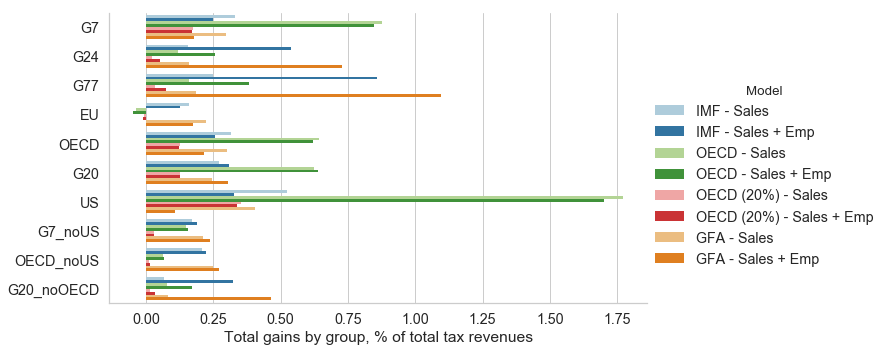

/home/javiergb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
High Income,21.51%,100753443614200.00%,0.27%,0.19%,0.30%,0.25%,0.14%,0.14%,0.72%,0.70%
LICs,-19.99%,-26976681300.00%,0.61%,1.14%,0.77%,1.13%,0.01%,0.04%,0.05%,0.18%
LMICs,44.02%,2022866995800.00%,-0.19%,1.35%,-0.03%,1.01%,0.03%,0.10%,0.15%,0.52%
Tax haven,5.03%,34446744760800.00%,-4.01%,-6.02%,-4.06%,-5.41%,-1.75%,-1.84%,-8.73%,-9.21%
UMICs,42.28%,4573338143800.00%,0.19%,0.53%,0.18%,0.41%,0.02%,0.04%,0.11%,0.19%


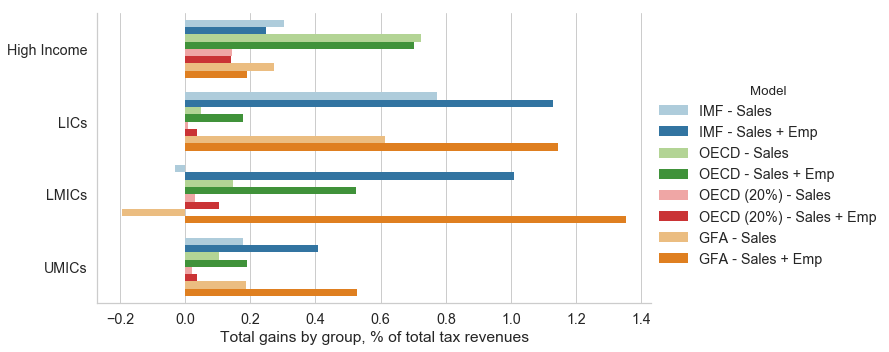

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
High Income,21.51%,100753443614200.00%,27.36%,18.96%,30.50%,24.85%,14.45%,14.04%,72.25%,70.22%
LICs,-19.99%,-26976681300.00%,61.39%,114.47%,77.20%,112.86%,0.97%,3.55%,4.85%,17.73%
LMICs,44.02%,2022866995800.00%,-19.23%,135.24%,-2.95%,100.83%,2.97%,10.46%,14.83%,52.29%
Tax haven,5.03%,34446744760800.00%,-401.03%,-601.88%,-405.76%,-540.70%,-174.53%,-184.27%,-872.64%,-921.35%
UMICs,42.28%,4573338143800.00%,18.59%,52.86%,17.90%,40.92%,2.11%,3.77%,10.55%,18.86%


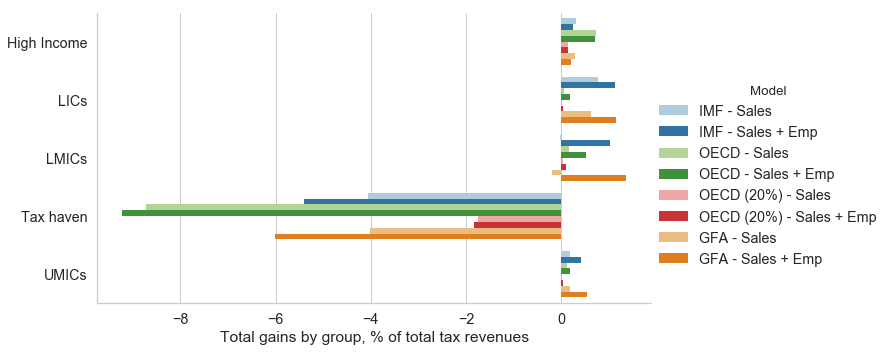

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
East Asia & Pacific,20.75%,10696023740200.00%,-0.42%,8.37%,-3.02%,2.89%,-0.21%,0.22%,-1.04%,1.09%
Europe & Central Asia,24.37%,13717393143000.00%,27.81%,22.25%,21.67%,17.93%,0.11%,-0.16%,0.57%,-0.78%
Latin America & The Caribbean,26.31%,4211955833200.00%,64.30%,165.17%,64.98%,132.74%,4.67%,9.56%,23.37%,47.82%
Middle East & North Africa,48.72%,982120535700.00%,-31.21%,-16.82%,-24.38%,-14.72%,-11.38%,-10.69%,-56.92%,-53.43%
North America,20.49%,88544703887200.00%,43.41%,18.36%,55.70%,38.88%,32.98%,31.76%,164.88%,158.81%
South Asia,34.11%,1295666970700.00%,-39.51%,153.03%,-43.75%,85.60%,2.64%,11.98%,13.20%,59.89%
Sub - Saharan Africa,79.24%,372046486900.00%,47.32%,73.64%,116.03%,133.71%,-0.28%,0.99%,-1.42%,4.96%


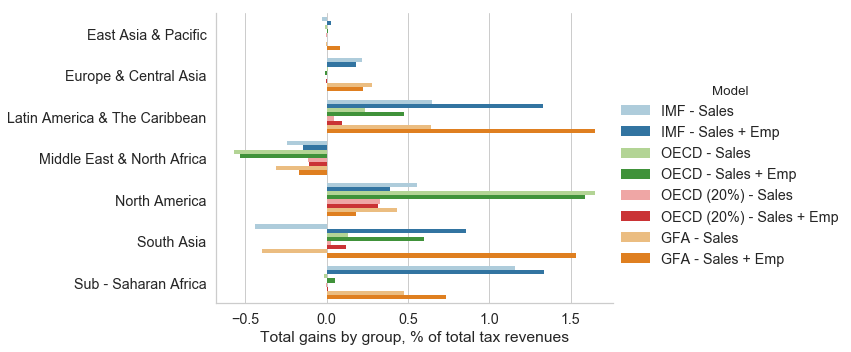

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
EU,20.84%,13935292512900.00%,349.51%,277.58%,250.07%,201.74%,-11.00%,-14.48%,-54.98%,-72.42%
G20,22.13%,101780884633100.00%,249.90%,309.10%,274.97%,314.74%,126.91%,129.78%,634.55%,648.90%
G20_noOECD,37.20%,4108709924900.00%,60.06%,342.87%,50.57%,240.57%,11.66%,25.37%,58.29%,126.87%
G24,48.05%,4794226878300.00%,113.21%,514.38%,110.60%,380.11%,16.84%,36.30%,84.22%,181.51%
G7,20.97%,95942419792800.00%,383.62%,231.48%,425.09%,322.88%,225.66%,218.28%,1128.28%,1091.39%
G77,44.48%,3813733321900.00%,163.14%,957.67%,217.09%,750.86%,28.27%,66.80%,141.33%,334.00%
G7_noUS,26.85%,9157215162500.00%,254.43%,285.27%,206.18%,226.89%,36.05%,37.54%,180.24%,187.71%
OECD,21.55%,106811442611900.00%,356.39%,254.73%,373.35%,305.06%,151.61%,146.68%,758.07%,733.42%
OECD_noUS,26.77%,20026237981600.00%,271.68%,294.69%,227.62%,243.07%,13.87%,14.98%,69.33%,74.91%


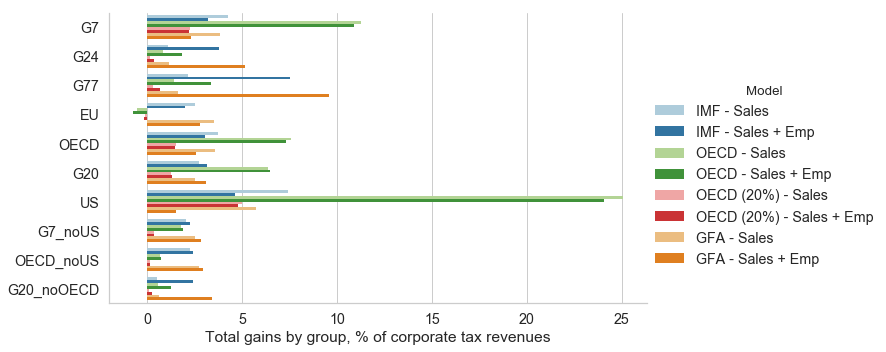

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
High Income,21.51%,100753443614200.00%,3.34%,2.31%,3.72%,3.03%,1.76%,1.71%,8.82%,8.57%
LICs,-19.99%,-26976681300.00%,11.82%,22.04%,14.87%,21.73%,0.19%,0.68%,0.93%,3.41%
LMICs,44.02%,2022866995800.00%,-1.64%,11.51%,-0.25%,8.58%,0.25%,0.89%,1.26%,4.45%
Tax haven,5.03%,34446744760800.00%,-31.76%,-47.66%,-32.13%,-42.82%,-13.82%,-14.59%,-69.11%,-72.96%
UMICs,42.28%,4573338143800.00%,1.27%,3.61%,1.22%,2.80%,0.14%,0.26%,0.72%,1.29%


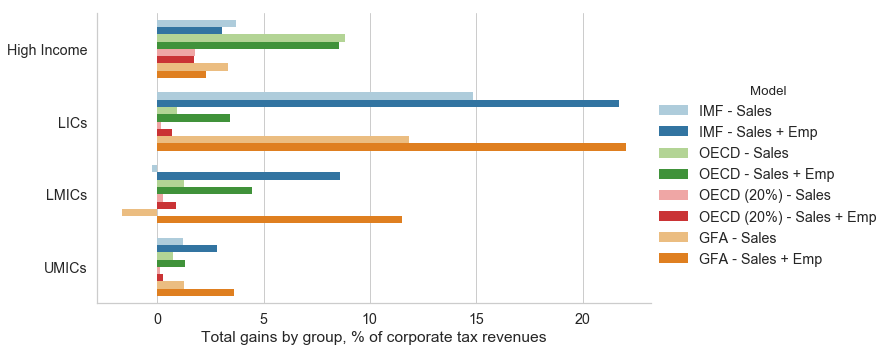

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
High Income,21.51%,100753443614200.00%,334.01%,231.42%,372.24%,303.32%,176.38%,171.41%,881.92%,857.05%
LICs,-19.99%,-26976681300.00%,1182.15%,2204.19%,1486.56%,2173.17%,18.69%,68.26%,93.47%,341.31%
LMICs,44.02%,2022866995800.00%,-163.61%,1150.88%,-25.06%,858.02%,25.24%,88.99%,126.21%,444.97%
Tax haven,5.03%,34446744760800.00%,-3175.83%,-4766.40%,-3213.31%,-4281.87%,-1382.12%,-1459.26%,-6910.60%,-7296.30%
UMICs,42.28%,4573338143800.00%,127.05%,361.28%,122.34%,279.69%,14.43%,25.79%,72.13%,128.93%


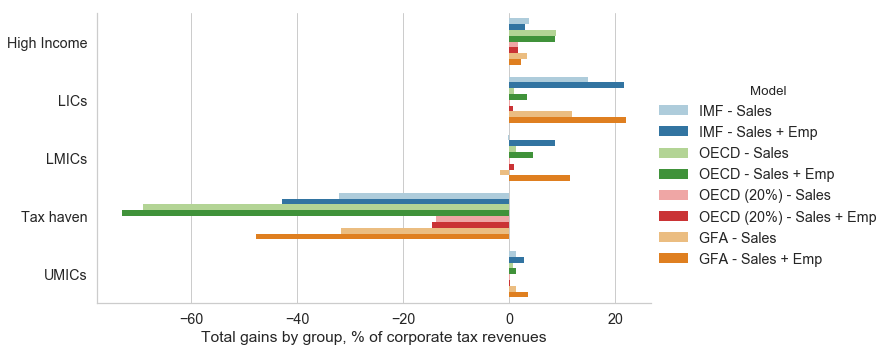

Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
East Asia & Pacific,20.75%,10696023740200.00%,-2.53%,50.63%,-18.26%,17.45%,-1.26%,1.32%,-6.28%,6.61%
Europe & Central Asia,24.37%,13717393143000.00%,406.57%,325.29%,316.74%,262.14%,1.66%,-2.28%,8.31%,-11.40%
Latin America & The Caribbean,26.31%,4211955833200.00%,497.14%,1276.95%,502.35%,1026.23%,36.13%,73.95%,180.64%,369.74%
Middle East & North Africa,48.72%,982120535700.00%,-194.85%,-105.05%,-152.24%,-91.90%,-71.07%,-66.71%,-355.35%,-333.57%
North America,20.49%,88544703887200.00%,587.74%,248.63%,754.22%,526.41%,446.51%,430.06%,2232.55%,2150.31%
South Asia,34.11%,1295666970700.00%,-3661.25%,14179.16%,-4054.10%,7931.23%,244.59%,1109.83%,1222.93%,5549.14%
Sub - Saharan Africa,79.24%,372046486900.00%,283.67%,441.44%,695.61%,801.60%,-1.71%,5.95%,-8.53%,29.73%


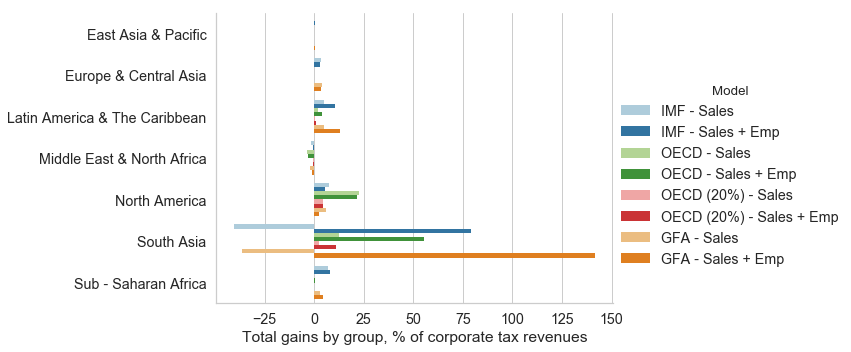

In [18]:
for x in ["M_%tot_tax","M_%cit"]:
    plot_bar(aggregates,title="",x=x,savefig="groups")
    print_summary(aggregates,values=x,table_name="groups",positive_gains=positive_gains)
    plt.show()
    
    
    no_tax_havens = inc_aggregate.loc[inc_aggregate["group"]!="Tax haven"]
    plot_bar(no_tax_havens,title="",x=x,savefig="income_no_tax_havens")
    print_summary(inc_aggregate,values=x,table_name="income_no_tax_havens",positive_gains=positive_gains)
    plt.show()
    
    plot_bar(inc_aggregate,title="",x=x,savefig="income")
    print_summary(inc_aggregate,values=x,table_name="income",positive_gains=positive_gains)
    plt.show()
    
    plot_bar(reg_aggregate,title="",x=x,savefig="region")
    print_summary(reg_aggregate,values=x,table_name="region",positive_gains=positive_gains)
    plt.show()

## 3.3 Plot individual countries
- within group (G7, OECD, G20, etc)

G7


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
CA,27.32%,1759499256900.00%,0.74%,0.95%,0.88%,1.02%,0.08%,0.09%,0.41%,0.46%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
FR,46.91%,479589932600.00%,0.27%,0.30%,0.22%,0.24%,0.02%,0.02%,0.10%,0.11%
GB,18.71%,2871953687200.00%,0.39%,0.45%,0.39%,0.43%,0.05%,0.05%,0.26%,0.27%
IT,45.39%,339982087300.00%,0.17%,0.17%,0.13%,0.13%,0.01%,0.01%,0.07%,0.07%
JP,25.62%,2595235594000.00%,-0.17%,-0.19%,-0.24%,-0.26%,0.02%,0.02%,0.09%,0.09%
US,20.35%,86785204630300.00%,0.40%,0.11%,0.53%,0.33%,0.35%,0.34%,1.77%,1.70%


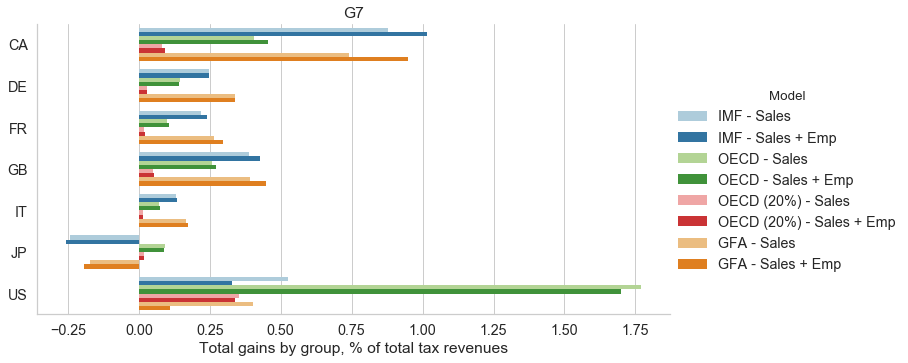

G24


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.09%,0.35%,0.05%,0.22%,0.03%,0.04%,0.15%,0.21%
BR,647.13%,36761424500.00%,0.66%,1.08%,0.68%,0.96%,0.03%,0.05%,0.17%,0.27%
CI,-19.03%,-5186952200.00%,0.65%,0.55%,0.57%,0.50%,0.02%,0.02%,0.11%,0.08%
CN,26.36%,1908310537900.00%,0.03%,0.18%,0.01%,0.11%,0.01%,0.02%,0.05%,0.09%
CO,69.26%,105540604200.00%,0.35%,0.85%,0.34%,0.67%,0.04%,0.07%,0.21%,0.33%
DZ,58.68%,121973060300.00%,-1.10%,-1.10%,-1.04%,-1.05%,0.01%,0.01%,0.06%,0.06%
EC,450.73%,2371351500.00%,0.49%,0.75%,0.47%,0.65%,0.03%,0.04%,0.13%,0.19%
EG,119.81%,43061366300.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
GA,-16.26%,-12724524700.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%


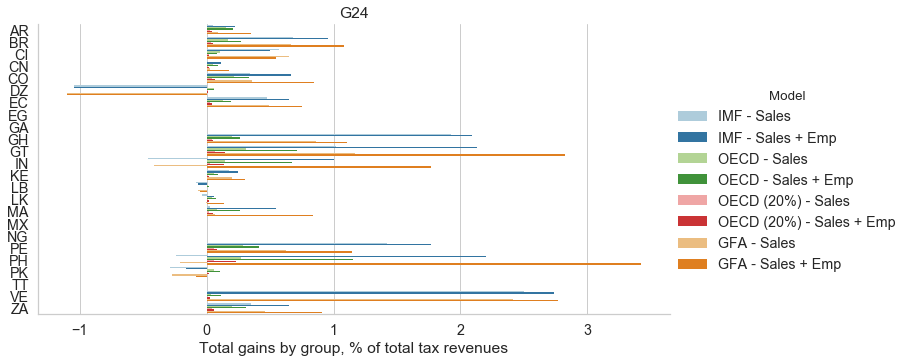

G77


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.09%,0.35%,0.05%,0.22%,0.03%,0.04%,0.15%,0.21%
BO,54.36%,1705012500.00%,0.11%,0.21%,0.12%,0.18%,0.01%,0.01%,0.04%,0.06%
BR,647.13%,36761424500.00%,0.66%,1.08%,0.68%,0.96%,0.03%,0.05%,0.17%,0.27%
CG,-10.65%,-42941666700.00%,11.30%,11.34%,17.40%,17.43%,0.05%,0.05%,0.26%,0.27%
CL,11.53%,425256390200.00%,-0.91%,-0.05%,-0.66%,-0.09%,0.06%,0.11%,0.32%,0.53%
CM,-25.22%,-3459058600.00%,0.32%,0.41%,0.32%,0.38%,0.00%,0.01%,0.01%,0.03%
CO,69.26%,105540604200.00%,0.35%,0.85%,0.34%,0.67%,0.04%,0.07%,0.21%,0.33%
CR,16.97%,79730748700.00%,0.10%,5.43%,-0.14%,3.45%,0.15%,0.41%,0.77%,2.06%
DO,11.34%,44857681400.00%,-0.57%,0.98%,-0.52%,0.52%,0.03%,0.11%,0.17%,0.54%


EU


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,0.12%,0.11%,0.09%,0.08%,0.01%,0.01%,0.06%,0.05%
BE,17.66%,644581766800.00%,0.74%,0.23%,0.60%,0.25%,0.09%,0.06%,0.44%,0.31%
BG,8.54%,20756744800.00%,0.01%,0.18%,0.03%,0.15%,0.01%,0.02%,0.03%,0.08%
CY,1.02%,152309138500.00%,-3.64%,-3.66%,-3.68%,-3.69%,-0.76%,-0.76%,-3.82%,-3.82%
CZ,16.57%,94254657400.00%,0.08%,0.46%,0.04%,0.31%,0.02%,0.04%,0.08%,0.18%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
DK,52.34%,98030539800.00%,0.07%,0.08%,0.05%,0.06%,0.01%,0.01%,0.06%,0.06%
EE,21.03%,5265533100.00%,-0.02%,0.17%,-0.03%,0.09%,0.01%,0.02%,0.03%,0.08%
ES,126.13%,91203319300.00%,0.39%,0.42%,0.33%,0.35%,0.02%,0.02%,0.11%,0.12%


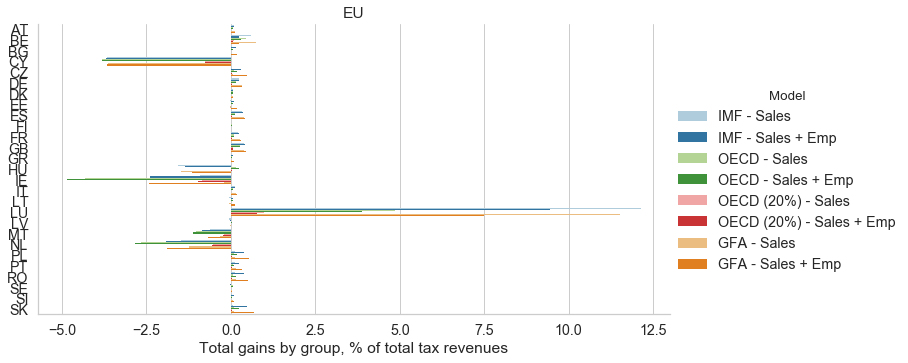

OECD


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,0.12%,0.11%,0.09%,0.08%,0.01%,0.01%,0.06%,0.05%
AU,107.83%,249482987100.00%,0.62%,0.73%,1.01%,1.08%,0.04%,0.05%,0.20%,0.23%
BE,17.66%,644581766800.00%,0.74%,0.23%,0.60%,0.25%,0.09%,0.06%,0.44%,0.31%
CA,27.32%,1759499256900.00%,0.74%,0.95%,0.88%,1.02%,0.08%,0.09%,0.41%,0.46%
CH,-27.91%,-620442813800.00%,3.02%,1.98%,2.52%,1.82%,0.23%,0.18%,1.17%,0.92%
CL,11.53%,425256390200.00%,-0.91%,-0.05%,-0.66%,-0.09%,0.06%,0.11%,0.32%,0.53%
CZ,16.57%,94254657400.00%,0.08%,0.46%,0.04%,0.31%,0.02%,0.04%,0.08%,0.18%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
DK,52.34%,98030539800.00%,0.07%,0.08%,0.05%,0.06%,0.01%,0.01%,0.06%,0.06%


G20


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.09%,0.35%,0.05%,0.22%,0.03%,0.04%,0.15%,0.21%
AU,107.83%,249482987100.00%,0.62%,0.73%,1.01%,1.08%,0.04%,0.05%,0.20%,0.23%
BR,647.13%,36761424500.00%,0.66%,1.08%,0.68%,0.96%,0.03%,0.05%,0.17%,0.27%
CA,27.32%,1759499256900.00%,0.74%,0.95%,0.88%,1.02%,0.08%,0.09%,0.41%,0.46%
CN,26.36%,1908310537900.00%,0.03%,0.18%,0.01%,0.11%,0.01%,0.02%,0.05%,0.09%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
FR,46.91%,479589932600.00%,0.27%,0.30%,0.22%,0.24%,0.02%,0.02%,0.10%,0.11%
GB,18.71%,2871953687200.00%,0.39%,0.45%,0.39%,0.43%,0.05%,0.05%,0.26%,0.27%
ID,29.48%,329364602300.00%,-0.47%,-0.21%,-0.21%,-0.03%,0.02%,0.03%,0.10%,0.17%


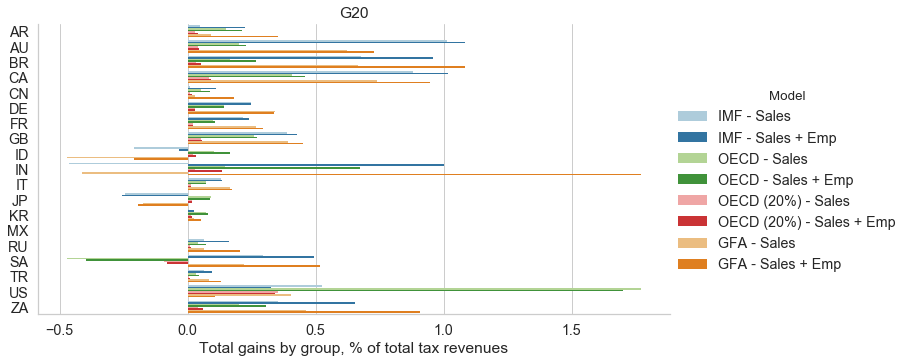

US


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
US,20.35%,86785204630300.00%,0.40%,0.11%,0.53%,0.33%,0.35%,0.34%,1.77%,1.70%


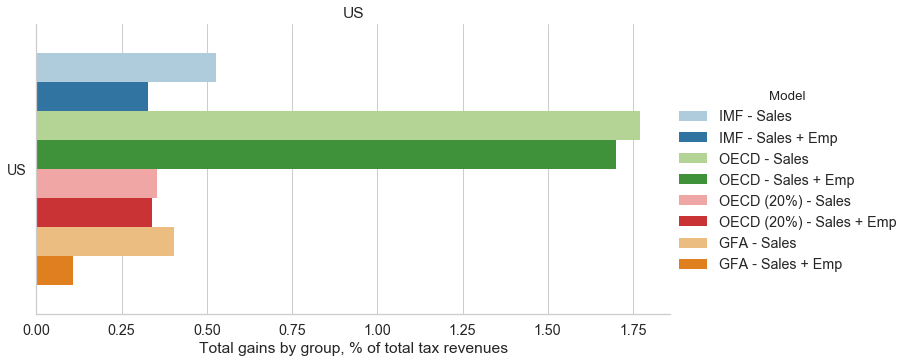

G7_noUS


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
CA,27.32%,1759499256900.00%,0.74%,0.95%,0.88%,1.02%,0.08%,0.09%,0.41%,0.46%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
FR,46.91%,479589932600.00%,0.27%,0.30%,0.22%,0.24%,0.02%,0.02%,0.10%,0.11%
GB,18.71%,2871953687200.00%,0.39%,0.45%,0.39%,0.43%,0.05%,0.05%,0.26%,0.27%
IT,45.39%,339982087300.00%,0.17%,0.17%,0.13%,0.13%,0.01%,0.01%,0.07%,0.07%
JP,25.62%,2595235594000.00%,-0.17%,-0.19%,-0.24%,-0.26%,0.02%,0.02%,0.09%,0.09%


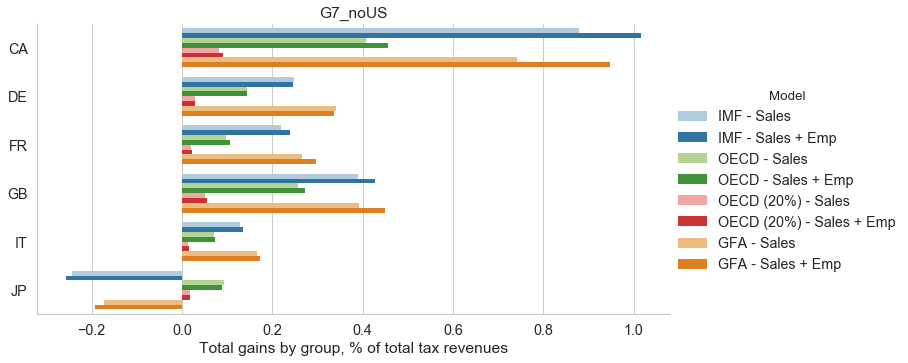

OECD_noUS


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,0.12%,0.11%,0.09%,0.08%,0.01%,0.01%,0.06%,0.05%
AU,107.83%,249482987100.00%,0.62%,0.73%,1.01%,1.08%,0.04%,0.05%,0.20%,0.23%
BE,17.66%,644581766800.00%,0.74%,0.23%,0.60%,0.25%,0.09%,0.06%,0.44%,0.31%
CA,27.32%,1759499256900.00%,0.74%,0.95%,0.88%,1.02%,0.08%,0.09%,0.41%,0.46%
CH,-27.91%,-620442813800.00%,3.02%,1.98%,2.52%,1.82%,0.23%,0.18%,1.17%,0.92%
CL,11.53%,425256390200.00%,-0.91%,-0.05%,-0.66%,-0.09%,0.06%,0.11%,0.32%,0.53%
CZ,16.57%,94254657400.00%,0.08%,0.46%,0.04%,0.31%,0.02%,0.04%,0.08%,0.18%
DE,35.68%,1110954604500.00%,0.34%,0.34%,0.25%,0.25%,0.03%,0.03%,0.14%,0.14%
DK,52.34%,98030539800.00%,0.07%,0.08%,0.05%,0.06%,0.01%,0.01%,0.06%,0.06%


G20_noOECD


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.09%,0.35%,0.05%,0.22%,0.03%,0.04%,0.15%,0.21%
BR,647.13%,36761424500.00%,0.66%,1.08%,0.68%,0.96%,0.03%,0.05%,0.17%,0.27%
CN,26.36%,1908310537900.00%,0.03%,0.18%,0.01%,0.11%,0.01%,0.02%,0.05%,0.09%
ID,29.48%,329364602300.00%,-0.47%,-0.21%,-0.21%,-0.03%,0.02%,0.03%,0.10%,0.17%
IN,33.93%,1203085791100.00%,-0.41%,1.77%,-0.46%,1.00%,0.03%,0.13%,0.14%,0.67%
RU,40.12%,196767730900.00%,0.06%,0.20%,0.07%,0.16%,0.01%,0.01%,0.04%,0.07%
SA,41.91%,75347480100.00%,0.22%,0.52%,0.29%,0.49%,-0.09%,-0.08%,-0.47%,-0.40%
ZA,33.23%,111208765300.00%,0.46%,0.91%,0.35%,0.65%,0.04%,0.06%,0.20%,0.31%


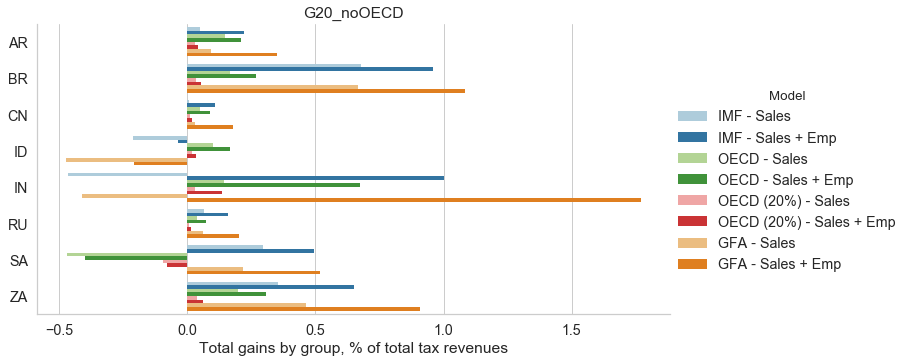

All


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AE,46.39%,330003118100.00%,-1.03%,-1.38%,-1.01%,-1.24%,-0.70%,-0.71%,-3.49%,-3.57%
AL,62.05%,255083500.00%,-0.00%,0.03%,0.00%,0.02%,0.00%,0.00%,0.00%,0.01%
AM,103.90%,35220500.00%,0.02%,0.11%,0.02%,0.08%,0.00%,0.01%,0.01%,0.03%
AO,-103.78%,-47736726600.00%,2.02%,2.03%,4.25%,4.26%,0.05%,0.05%,0.26%,0.26%
AR,54.46%,247863592800.00%,0.09%,0.35%,0.05%,0.22%,0.03%,0.04%,0.15%,0.21%
AT,37.19%,68515361700.00%,0.12%,0.11%,0.09%,0.08%,0.01%,0.01%,0.06%,0.05%
AU,107.83%,249482987100.00%,0.62%,0.73%,1.01%,1.08%,0.04%,0.05%,0.20%,0.23%
AW,10.55%,17618823300.00%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%
AZ,-60.13%,-12325922300.00%,0.79%,0.73%,1.30%,1.26%,0.02%,0.02%,0.10%,0.08%


G7


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
CA,27.32%,1759499256900.00%,6.99%,8.93%,8.29%,9.60%,0.77%,0.86%,3.84%,4.31%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
FR,46.91%,479589932600.00%,5.24%,5.84%,4.30%,4.70%,0.39%,0.42%,1.94%,2.09%
GB,18.71%,2871953687200.00%,4.60%,5.28%,4.57%,5.03%,0.61%,0.64%,3.03%,3.20%
IT,45.39%,339982087300.00%,3.34%,3.49%,2.61%,2.71%,0.29%,0.30%,1.44%,1.48%
JP,25.62%,2595235594000.00%,-1.23%,-1.37%,-1.74%,-1.83%,0.13%,0.12%,0.66%,0.62%
US,20.35%,86785204630300.00%,5.71%,1.53%,7.43%,4.62%,5.01%,4.81%,25.06%,24.04%


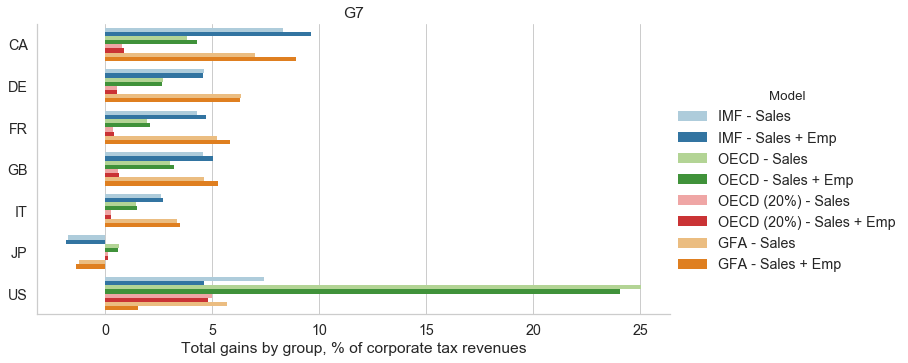

G24


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.99%,3.78%,0.52%,2.40%,0.32%,0.46%,1.60%,2.28%
BR,647.13%,36761424500.00%,8.08%,13.16%,8.23%,11.64%,0.40%,0.65%,2.02%,3.25%
CI,-19.03%,-5186952200.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
CN,26.36%,1908310537900.00%,0.18%,1.10%,0.05%,0.68%,0.06%,0.11%,0.31%,0.53%
CO,69.26%,105540604200.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
DZ,58.68%,121973060300.00%,-inf%,-inf%,-inf%,-inf%,inf%,inf%,inf%,inf%
EC,450.73%,2371351500.00%,6.82%,10.36%,6.54%,8.92%,0.36%,0.53%,1.78%,2.64%
EG,119.81%,43061366300.00%,0.99%,1.91%,1.21%,1.82%,0.09%,0.14%,0.46%,0.68%
GA,-16.26%,-12724524700.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%


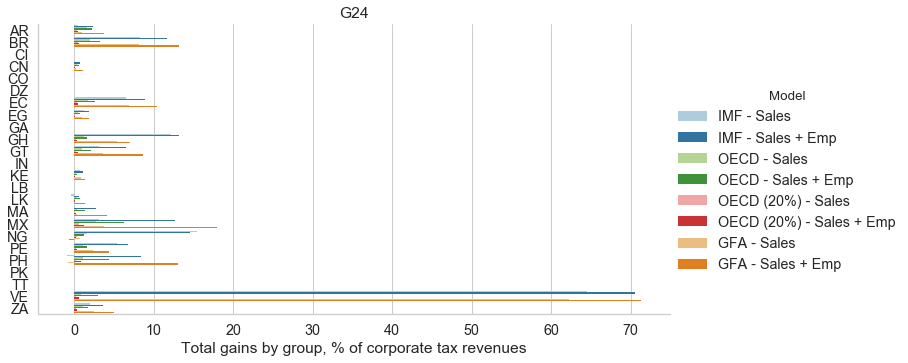

G77


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.99%,3.78%,0.52%,2.40%,0.32%,0.46%,1.60%,2.28%
BO,54.36%,1705012500.00%,0.65%,1.23%,0.67%,1.05%,0.04%,0.07%,0.21%,0.35%
BR,647.13%,36761424500.00%,8.08%,13.16%,8.23%,11.64%,0.40%,0.65%,2.02%,3.25%
CG,-10.65%,-42941666700.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
CL,11.53%,425256390200.00%,-3.71%,-0.22%,-2.70%,-0.35%,0.26%,0.43%,1.30%,2.15%
CM,-25.22%,-3459058600.00%,1.81%,2.29%,1.80%,2.12%,0.02%,0.04%,0.08%,0.19%
CO,69.26%,105540604200.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
CR,16.97%,79730748700.00%,0.46%,25.66%,-0.64%,16.29%,0.72%,1.95%,3.62%,9.73%
DO,11.34%,44857681400.00%,-3.42%,5.87%,-3.12%,3.12%,0.20%,0.65%,0.99%,3.25%


EU


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,2.08%,1.91%,1.52%,1.40%,0.19%,0.18%,0.93%,0.89%
BE,17.66%,644581766800.00%,7.98%,2.44%,6.45%,2.73%,0.94%,0.67%,4.69%,3.34%
BG,8.54%,20756744800.00%,0.08%,2.30%,0.42%,1.91%,0.09%,0.19%,0.44%,0.97%
CY,1.02%,152309138500.00%,-15.80%,-15.86%,-15.95%,-15.99%,-3.31%,-3.31%,-16.56%,-16.57%
CZ,16.57%,94254657400.00%,0.72%,4.38%,0.42%,2.88%,0.16%,0.33%,0.78%,1.66%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
DK,52.34%,98030539800.00%,0.99%,1.14%,0.76%,0.87%,0.17%,0.17%,0.84%,0.87%
EE,21.03%,5265533100.00%,-0.39%,3.63%,-0.68%,2.02%,0.13%,0.32%,0.63%,1.60%
ES,126.13%,91203319300.00%,5.71%,6.10%,4.79%,5.06%,0.32%,0.34%,1.60%,1.69%


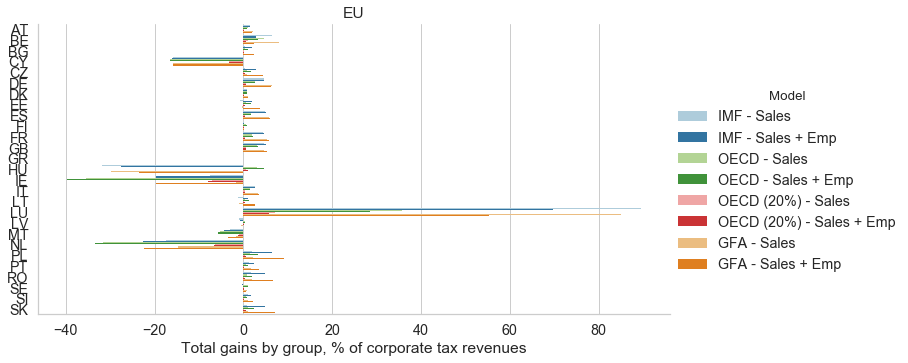

OECD


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,2.08%,1.91%,1.52%,1.40%,0.19%,0.18%,0.93%,0.89%
AU,107.83%,249482987100.00%,3.77%,4.41%,6.14%,6.57%,0.24%,0.27%,1.22%,1.37%
BE,17.66%,644581766800.00%,7.98%,2.44%,6.45%,2.73%,0.94%,0.67%,4.69%,3.34%
CA,27.32%,1759499256900.00%,6.99%,8.93%,8.29%,9.60%,0.77%,0.86%,3.84%,4.31%
CH,-27.91%,-620442813800.00%,26.36%,17.28%,22.03%,15.93%,2.05%,1.61%,10.26%,8.05%
CL,11.53%,425256390200.00%,-3.71%,-0.22%,-2.70%,-0.35%,0.26%,0.43%,1.30%,2.15%
CZ,16.57%,94254657400.00%,0.72%,4.38%,0.42%,2.88%,0.16%,0.33%,0.78%,1.66%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
DK,52.34%,98030539800.00%,0.99%,1.14%,0.76%,0.87%,0.17%,0.17%,0.84%,0.87%


G20


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.99%,3.78%,0.52%,2.40%,0.32%,0.46%,1.60%,2.28%
AU,107.83%,249482987100.00%,3.77%,4.41%,6.14%,6.57%,0.24%,0.27%,1.22%,1.37%
BR,647.13%,36761424500.00%,8.08%,13.16%,8.23%,11.64%,0.40%,0.65%,2.02%,3.25%
CA,27.32%,1759499256900.00%,6.99%,8.93%,8.29%,9.60%,0.77%,0.86%,3.84%,4.31%
CN,26.36%,1908310537900.00%,0.18%,1.10%,0.05%,0.68%,0.06%,0.11%,0.31%,0.53%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
FR,46.91%,479589932600.00%,5.24%,5.84%,4.30%,4.70%,0.39%,0.42%,1.94%,2.09%
GB,18.71%,2871953687200.00%,4.60%,5.28%,4.57%,5.03%,0.61%,0.64%,3.03%,3.20%
ID,29.48%,329364602300.00%,-1.22%,-0.54%,-0.54%,-0.09%,0.05%,0.09%,0.26%,0.43%


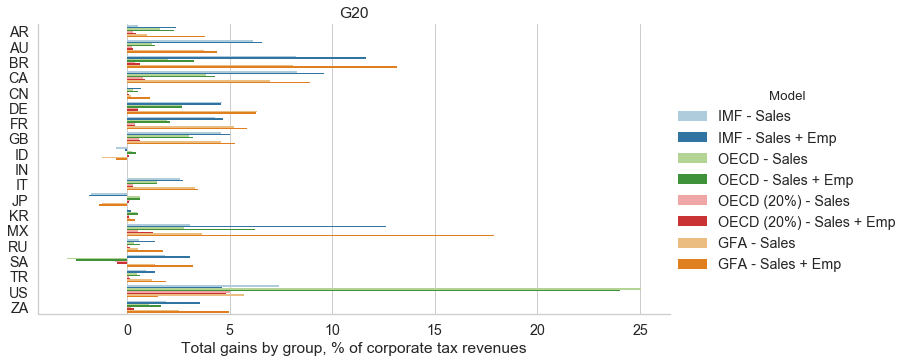

US


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
US,20.35%,86785204630300.00%,5.71%,1.53%,7.43%,4.62%,5.01%,4.81%,25.06%,24.04%


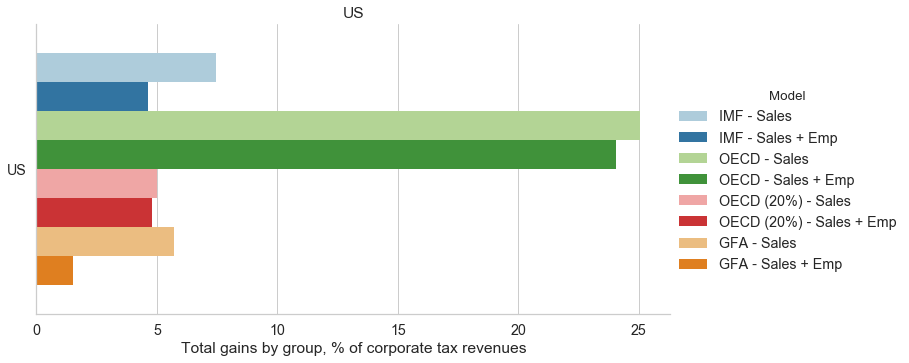

G7_noUS


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
CA,27.32%,1759499256900.00%,6.99%,8.93%,8.29%,9.60%,0.77%,0.86%,3.84%,4.31%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
FR,46.91%,479589932600.00%,5.24%,5.84%,4.30%,4.70%,0.39%,0.42%,1.94%,2.09%
GB,18.71%,2871953687200.00%,4.60%,5.28%,4.57%,5.03%,0.61%,0.64%,3.03%,3.20%
IT,45.39%,339982087300.00%,3.34%,3.49%,2.61%,2.71%,0.29%,0.30%,1.44%,1.48%
JP,25.62%,2595235594000.00%,-1.23%,-1.37%,-1.74%,-1.83%,0.13%,0.12%,0.66%,0.62%


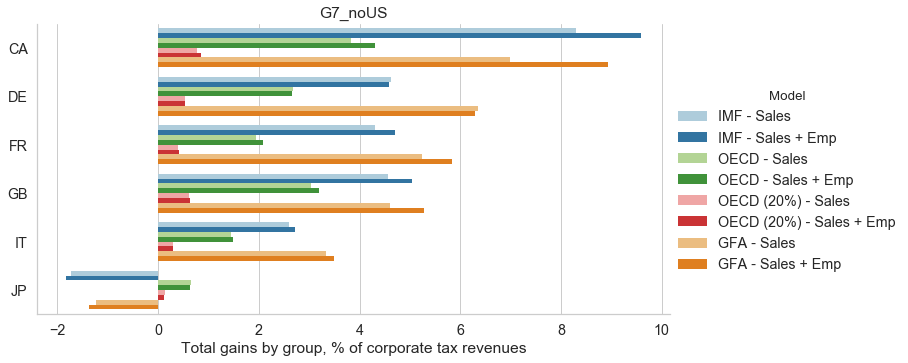

OECD_noUS


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AT,37.19%,68515361700.00%,2.08%,1.91%,1.52%,1.40%,0.19%,0.18%,0.93%,0.89%
AU,107.83%,249482987100.00%,3.77%,4.41%,6.14%,6.57%,0.24%,0.27%,1.22%,1.37%
BE,17.66%,644581766800.00%,7.98%,2.44%,6.45%,2.73%,0.94%,0.67%,4.69%,3.34%
CA,27.32%,1759499256900.00%,6.99%,8.93%,8.29%,9.60%,0.77%,0.86%,3.84%,4.31%
CH,-27.91%,-620442813800.00%,26.36%,17.28%,22.03%,15.93%,2.05%,1.61%,10.26%,8.05%
CL,11.53%,425256390200.00%,-3.71%,-0.22%,-2.70%,-0.35%,0.26%,0.43%,1.30%,2.15%
CZ,16.57%,94254657400.00%,0.72%,4.38%,0.42%,2.88%,0.16%,0.33%,0.78%,1.66%
DE,35.68%,1110954604500.00%,6.35%,6.29%,4.62%,4.58%,0.54%,0.53%,2.68%,2.67%
DK,52.34%,98030539800.00%,0.99%,1.14%,0.76%,0.87%,0.17%,0.17%,0.84%,0.87%


G20_noOECD


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AR,54.46%,247863592800.00%,0.99%,3.78%,0.52%,2.40%,0.32%,0.46%,1.60%,2.28%
BR,647.13%,36761424500.00%,8.08%,13.16%,8.23%,11.64%,0.40%,0.65%,2.02%,3.25%
CN,26.36%,1908310537900.00%,0.18%,1.10%,0.05%,0.68%,0.06%,0.11%,0.31%,0.53%
ID,29.48%,329364602300.00%,-1.22%,-0.54%,-0.54%,-0.09%,0.05%,0.09%,0.26%,0.43%
IN,33.93%,1203085791100.00%,-inf%,inf%,-inf%,inf%,inf%,inf%,inf%,inf%
RU,40.12%,196767730900.00%,0.54%,1.76%,0.57%,1.39%,0.07%,0.13%,0.34%,0.63%
SA,41.91%,75347480100.00%,1.37%,3.22%,1.84%,3.08%,-0.59%,-0.50%,-2.93%,-2.48%
ZA,33.23%,111208765300.00%,2.52%,4.95%,1.92%,3.55%,0.22%,0.34%,1.09%,1.68%


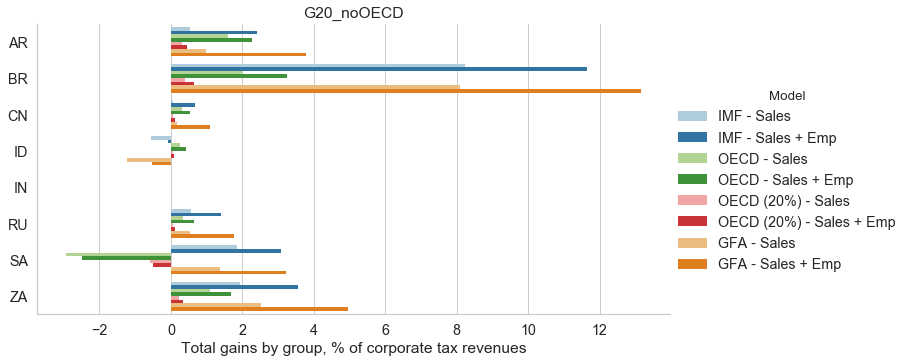

All


Model,M_ETR,M_PL,GFA - Sales,GFA - Sales + Emp,IMF - Sales,IMF - Sales + Emp,OECD (20%) - Sales,OECD (20%) - Sales + Emp,OECD - Sales,OECD - Sales + Emp
group,,,,,,,,,,
AE,46.39%,330003118100.00%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%
AL,62.05%,255083500.00%,-0.02%,0.39%,0.00%,0.28%,0.01%,0.03%,0.03%,0.13%
AM,103.90%,35220500.00%,0.18%,0.82%,0.13%,0.57%,0.01%,0.04%,0.05%,0.21%
AO,-103.78%,-47736726600.00%,inf%,inf%,inf%,inf%,inf%,inf%,inf%,inf%
AR,54.46%,247863592800.00%,0.99%,3.78%,0.52%,2.40%,0.32%,0.46%,1.60%,2.28%
AT,37.19%,68515361700.00%,2.08%,1.91%,1.52%,1.40%,0.19%,0.18%,0.93%,0.89%
AU,107.83%,249482987100.00%,3.77%,4.41%,6.14%,6.57%,0.24%,0.27%,1.22%,1.37%
AW,10.55%,17618823300.00%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%,-inf%
AZ,-60.13%,-12325922300.00%,3.20%,2.98%,5.29%,5.13%,0.08%,0.07%,0.39%,0.33%


In [19]:
## 3.4 Plot individual countries
for x in ["M_%tot_tax","M_%cit"]:
    for label in d_inc:
        print(label)
        if label == "All":
            #save all countries for appendix
            print_summary(d_inc[label],x,table_name="individual_countries")
        else:
            print_summary(d_inc[label],x)
        if len(d_inc[label]["group"].unique()) > 28:
            continue #Don't plot
        plot_bar(d_inc[label],title="",x=x,savefig="{}_individualcountries".format(label))
        plt.title(label)
        plt.show()


# 4. Plots using distributions and scatter plots of all countries 
  

## 4.1 Format data

In [20]:
##Create long format of the data with all countries
cols_totax = ["gains_{}_%tot_tax".format(_) for _ in range(1,len(models)+1)]
cols_cit = ["gains_{}_%cit".format(_) for _ in range(1,len(models)+1)]
merged_long1 = merged.melt(id_vars=["Country","ISO2","Inc","CIT"],value_vars=cols_totax,
            value_name="M_%tot_tax",var_name="Model")
merged_long2 = merged.melt(id_vars=["Country","ISO2","Inc","CIT"],value_vars=cols_cit,
            value_name="M_%cit",var_name="Model")
merged_long1["Model"] = merged_long1["Model"].str.replace("gains_","").str.replace("_%tot_tax","").str.replace("_%cit","").astype(int)
merged_long1["Model"] = merged_long1["Model"].map(d_models)
merged_long2["Model"] = merged_long2["Model"].str.replace("gains_","").str.replace("_%tot_tax","").str.replace("_%cit","").astype(int)
merged_long2["Model"] = merged_long2["Model"].map(d_models)

merged_long = pd.merge(merged_long1,merged_long2,how="outer")

merged_long["M_%tot_tax"]*=100
merged_long["M_%cit"]*=100
merged_long.head()

,Country,ISO2,Inc,CIT,Model,M_%tot_tax,M_%cit
0,All jurisdictions,World,NaN,NaN,IMF - Sales,NaN,NaN
1,United States,US,High Income,0.40,IMF - Sales,0.525316,7.431748
2,Stateless entities and other country,Stateless,Tax haven,0.35,IMF - Sales,NaN,NaN
3,Algeria,DZ,UMICs,0.25,IMF - Sales,-1.044621,NaN
4,Angola,AO,LMICs,0.32,IMF - Sales,4.252559,NaN


### 4.2 A boxplot of the distributions  (only for the data with all countries)

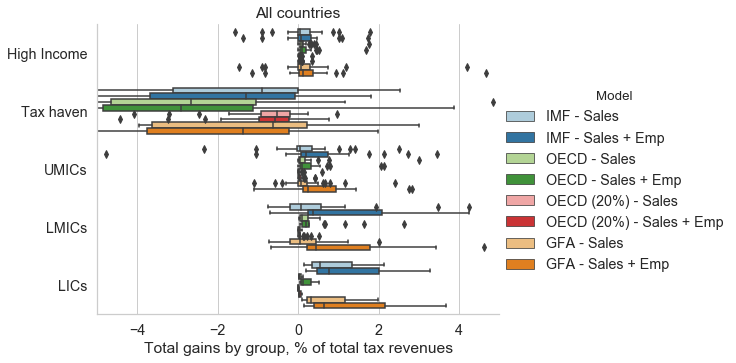

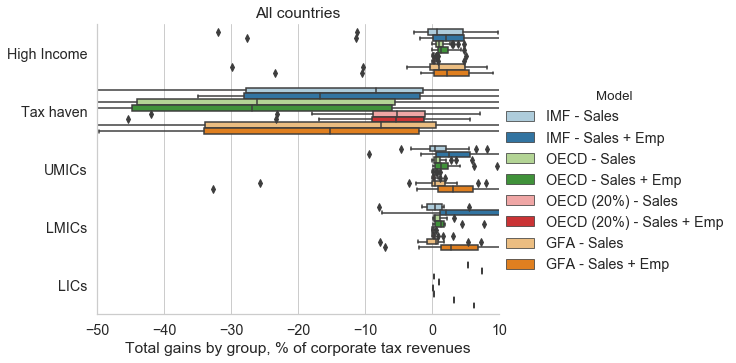

In [21]:
#Distribution of countries
sns.catplot(y="Inc",x="M_%tot_tax",hue="Model",data=merged_long,aspect=1.6,kind="box",palette="Paired")
plt.xlim(-5,5)
plt.xlabel("Total gains by group, % of total tax revenues")
plt.ylabel("")
plt.title("All countries")
plt.savefig(path_results+"/Figures/all_countries_tot_tax_dist.pdf")
plt.savefig(path_results+"/Figures/all_countries_tot_tax_dist.png")

#Distribution of countries
sns.catplot(y="Inc",x="M_%cit",hue="Model",data=merged_long,aspect=1.6,kind="box",palette="Paired")
plt.xlim(-50,10)
plt.xlabel("Total gains by group, % of corporate tax revenues")
plt.ylabel("")
plt.title("All countries")
plt.savefig(path_results+"/Figures/all_countries_cit_dist.pdf")
plt.savefig(path_results+"/Figures/all_countries_cit_dist.png")

### 4.3 Scatter plots
- CIT vs "Total gains as % of total tax revenue" (only for the data with all countries)
- CIT vs "Total gains as % of corporate tax revenue" (only for the data with all countries)

In [22]:
interesting_countries = ["US","ZA","IN","MU","CN","NL","IE","BM","SG","CA","BR","KE"]

In [23]:
def create_label(code):
    """
    Returns the long (formatted) label
    """
    if code == "CIT":
        return  "Statutory CIT"
    elif code == "M_%tot_tax":
        return "Gains, \n% total tax"
    elif code == "M_%cit":
        return "Gains, \n% of corporate tax"
    else:
        return ""

def plot_scatter(x_t,y_t,m,xmin=-4,xmax=3,ymin=-4,ymax=3):
    """
    Plot the scatter plot for one model, with the limits
    """
    texts = []
    
    plt.scatter(m[x_t],m[y_t],color="darkgray")
    for country,iso,x,y in zip(m["Country"],m["ISO2"],m[x_t],m[y_t]):
        if iso in interesting_countries:
            if np.isnan(x) or np.isnan(y) or (x < xmin)  or (x>xmax) or (y<ymin) or (y>ymax):
                continue
            texts.append(plt.text(x, y, country,fontsize=12))
            plt.scatter(x,y,s=40,color="royalblue")
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k',alpha=0.5))
    plt.grid(False)
    sns.despine()

    
def plot_all_models_scatter(merged_long,x_t="CIT",y_t="M_%tot_tax"):
    """
    Plot all the scatter plots for all models
    """
    plt.figure(figsize=(16,6))
    i = 0
    for model in merged_long["Model"].unique():
        i += 1
        plt.subplot(2,4,i)

        data  =merged_long.loc[merged_long["Model"]==model].copy()
        data[y_t+"_skew"] = np.sign(data[y_t])*np.sqrt(np.abs(data[y_t]))
        if x_t == "CIT":
            data["CIT"] *= 100
            xl = "CIT"
            xmin = 0
            xmax = 40
        else:
            data[x_t+"_skew"] = np.sign(data[x_t])*np.sqrt(np.abs(data[x_t]))
            xl = x_t+"_skew"
            xmin = -4
            xmax = 3
        if y_t == "M_%tot_tax":
            ymin = -4
            ymax = 3
        else:
            ymin = -8
            ymax = 5
            
        plot_scatter(xl,y_t+"_skew",data,xmin,xmax,ymin,ymax)
        plt.annotate(model,(0,ymin),fontsize=14,weight='bold')
        plt.plot([xmin,xmax],[0,0],color="lightgray")
        if i >4:
            plt.xlabel(create_label(x_t))
        if i%4 == 1:
            plt.ylabel(create_label(y_t))
        
        plt.yticks(range(ymin,ymax),[np.sign(_)*_**2 for _ in range(ymin,ymax)])
        plt.ylim(ymin,ymax)
        
   
        plt.xlim(xmin,xmax)
    plt.tight_layout()


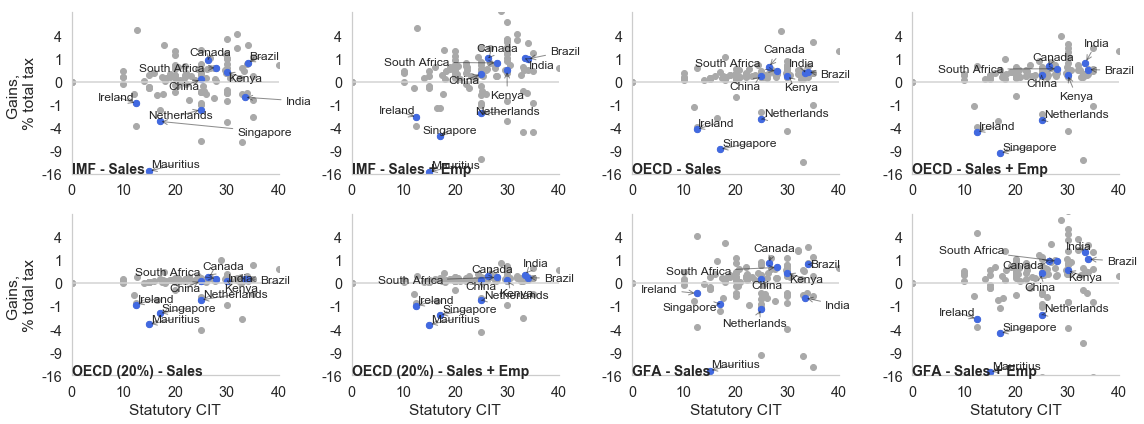

In [24]:
#Plot and save
plot_all_models_scatter(merged_long,"CIT","M_%tot_tax")
plt.savefig(path_results+"/Figures/all_models_scatter_plots_cit_vs_%tot_tax.pdf")
plt.savefig(path_results+"/Figures/all_models_scatter_plots_cit_vs_%tot_tax.png")

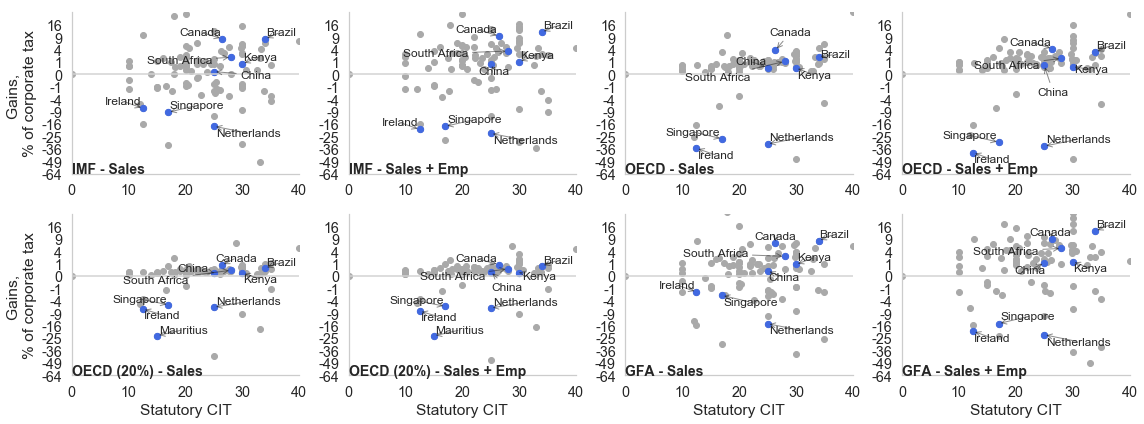

In [25]:
#Plot and save
plot_all_models_scatter(merged_long,"CIT","M_%cit")
plt.savefig(path_results+"/Figures/all_models_scatter_plots_%cit_vs_%tot_tax.pdf")
plt.savefig(path_results+"/Figures/all_models_scatter_plots_%cit_vs_%tot_tax.png")

# Step 5. Interactive viz
- Only for the data with all countries
- Note: Open the html file from the folder Figures, it won't work in github/nbviewer

/home/javiergb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


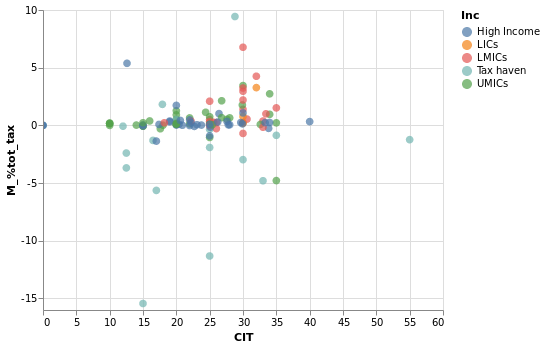

In [26]:
model2 = merged_long.loc[merged_long["Model"] == "IMF - Sales + Emp"]
model2["CIT"] *= 100
#Delete outliers
model2 = model2.loc[(model2["M_%tot_tax"]<10) & (model2["M_%tot_tax"]>-18)]

p = alt.Chart(model2).mark_circle(size=60).encode(
    x='CIT',
    y='M_%tot_tax',
    color='Inc',
    tooltip=['Country', 'CIT', 'M_%tot_tax', 'Inc']
).interactive()
p.save(path_results+"/Figures/scatter_CIT_tot_tax_model_IMF-S+E.html")
p


/home/javiergb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


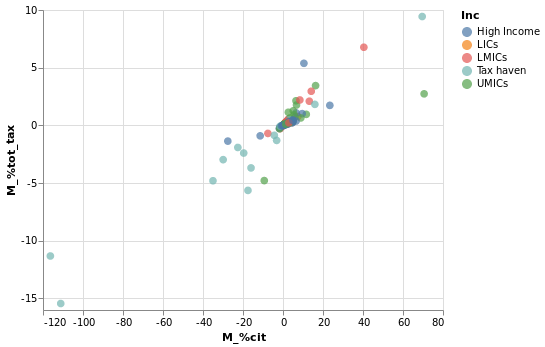

In [27]:
model2 = merged_long.loc[merged_long["Model"] == "IMF - Sales + Emp"]
model2["CIT"] *= 100
#Delete outliers
model2 = model2.loc[(model2["M_%tot_tax"]<10) & (model2["M_%tot_tax"]>-18)]

p = alt.Chart(model2).mark_circle(size=60).encode(
    x='M_%cit',
    y='M_%tot_tax',
    color='Inc',
    tooltip=['Country', 'CIT','M_%cit', 'M_%tot_tax', 'Inc']
).interactive()
p.save(path_results+"/Figures/scatter_%cit_tot_tax_model_IMF-S+E.html")
p
